In [12]:
from typing import List
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import random as rd
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler


from main import to_vect, Coordinates, calculate_asrs, classify_asrs, dataloader, dataloader_2024
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary


In [ ]:
def create_batches(dataloader, session_type: str, batch_size: int, scale : int = 20,
                   subsample : bool = False, asrs_calc = classify_asrs, augmentation : bool = False, shuffle : bool = True):
    trajectories = []
    asrs = []
    print("Iterating through dataloader...")
    for sample in tqdm(dataloader):
        session = sample[session_type]
        if session is not None:
            if sample.answers is not None:
                player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
                player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
                asrs_score = asrs_calc(sample.answers)
                if augmentation:
                    # Add 8 different rotations of the trajectory
                    for i in range(0, 8):
                        # rotate from 45°
                        theta = np.radians(45*i)
                        c, s = np.cos(theta), np.sin(theta)
                        R = np.array([[c, -s], [s, c]])
                        rotated_coords = np.dot(player_coords, R)
                        trajectories.append(rotated_coords)
                        asrs_std = 3.1191546250994713
                        ICC = 0.75
                        intraclass_var = asrs_std**2 * (1/ICC - 1)
                        simulated_asrs = rd.gauss(asrs_score, intraclass_var)
                        asrs.append(simulated_asrs)

                else :
                    trajectories.append(player_coords)
                    asrs.append(asrs_score)

    # Pad / Truncate trajectories
    length = 30000
    padded_trajectories = []
    for traj in trajectories:
        if len(traj) < length:
            padded_traj = np.pad(traj, ((0, length - len(traj)), (0, 0)), mode='edge')
        else :
            padded_traj = traj
        truncated_traj = padded_traj[:length]
        padded_trajectories.append(truncated_traj)

    # Subsample trajectories
    if subsample:
        length = length // scale
        trajectories = np.array([np.array_split(player_coords, scale) for player_coords in padded_trajectories])
        trajectories = np.concatenate(trajectories, axis=0)
        trajectories = [coords - coords[0] for coords in trajectories]
        asrs = np.array([asrs_score for asrs_score in asrs for _ in range(scale)])
    else:
        trajectories = list(padded_trajectories)  

    # Shuffle trajectories
    tensor_trajectories = torch.tensor(trajectories, dtype=torch.float32)
    if shuffle :
        seed = 42
        permute = torch.randperm(len(tensor_trajectories), generator=torch.Generator().manual_seed(seed))
        tensor_trajectories = tensor_trajectories[permute]
        asrs = np.array(asrs)[permute]

    # Create batches
    num_batches = min(len(tensor_trajectories), len(asrs)) // batch_size
    if len(asrs) == len(trajectories):
        batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
        asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
        # Reduce the sample rate
        batches = batches[:, :, ::25]    

    return batches, asrs

In [6]:
def data_setup(dataloader = dataloader, scale : int = 5, batch_size : int = 60, augmentation : bool = False):
    # Create batches for "uniform" and "patchy" session types
    uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size, subsample=True, scale=scale, augmentation=augmentation)
    patchy_batches,asrs_2 = create_batches(dataloader, "patchy", batch_size, subsample=True, scale=scale, augmentation=augmentation)
    asrs = torch.cat((asrs, asrs_2), 0)
    batches = torch.cat((uniform_batches, patchy_batches), 0)
    high_probability_adhd = torch.Tensor((np.array(asrs) >= 4).astype(int))

    print(f"Trajectory batches shape: {batches.shape}")
    print(f"Target batches shape: {high_probability_adhd.shape}")

    return batches, high_probability_adhd

# Test different scales

Creating batches...


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Creating batches...


100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


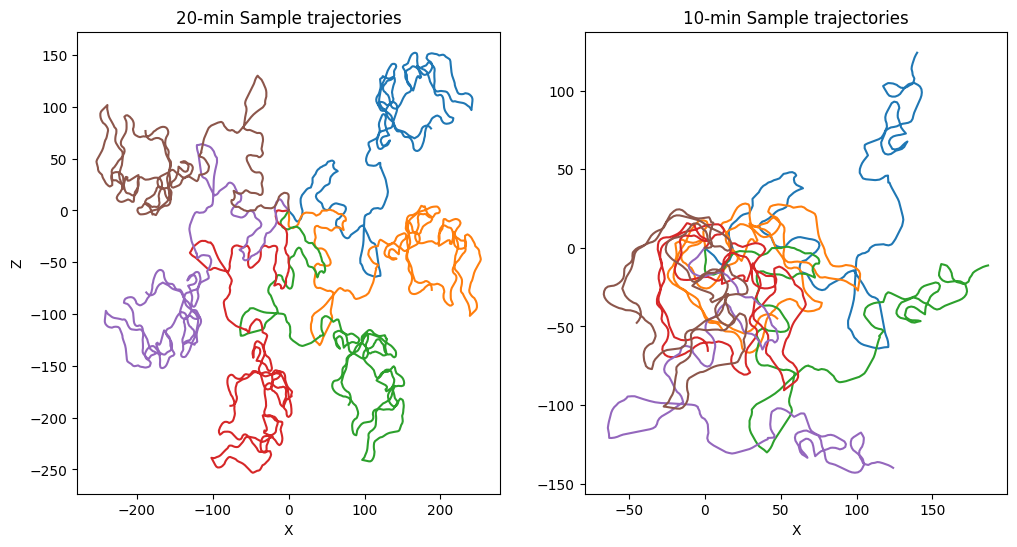

In [21]:
batch_size = 6
scales = [1,2]
x_1, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[0], subsample=True, augmentation=True, shuffle=False)
x_2, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[1], subsample=True, augmentation=True, shuffle=False)
duration_1, duration_2 = x_1.shape[2]//60, x_2.shape[2]//60

# Plot the first 10 trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(batch_size):
    axes[0].plot(x_1[0, i, :, 0].flatten(), x_1[0, i, :, 1].flatten(), label=f'{duration_1}-min trajectories {i+1}')
    axes[1].plot(x_2[0, i, :, 0].flatten(), x_2[0, i, :, 1].flatten(), label=f'{duration_2}-min trajectories {i+1}')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
axes[0].set_title(f'{duration_1}-min Sample trajectories')
axes[1].set_xlabel('X')
axes[1].set_title(f'{duration_2}-min Sample trajectories')
plt.show()

# Model definition

In [68]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, seq_len):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.dense1 = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(seq_len,1)
        self.activation = nn.Sigmoid()
        self.seq_len = seq_len

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(1, 0, 2)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.dense1(attention_out).view(-1, self.seq_len)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
input_dim = 2  # x and z coordinates
hidden_dim = 64
num_layers = 4
dropout = 0.5

In [69]:
class TemporalCNN(nn.Module):
    def __init__(self, seq_len, n_channels=2):
        super(TemporalCNN, self).__init__()
        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256, 1)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(seq_len, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, n_channels, seq_len)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, n_channels)
        x = self.fc1(x)
        x = self.relu3(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, 1, seq_len)
        x = self.fc2(x).flatten()
        x = self.sigmoid(x)
        return x.squeeze()

# Training

In [70]:
x_train, y_train = data_setup(dataloader=dataloader,scale=1, batch_size=6, augmentation=True)
x_test, y_test = data_setup(dataloader=dataloader_2024,scale=1, batch_size=6, augmentation=False)
seq_len = x_train.shape[2]

Iterating through dataloader...


100%|██████████| 39/39 [00:24<00:00,  1.58it/s]


Iterating through dataloader...


100%|██████████| 39/39 [00:22<00:00,  1.71it/s]


Trajectory batches shape: torch.Size([102, 6, 1200, 2])
Target batches shape: torch.Size([102, 6])
Iterating through dataloader...


100%|██████████| 19/19 [00:10<00:00,  1.77it/s]


Iterating through dataloader...


100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

Trajectory batches shape: torch.Size([2, 6, 1200, 2])
Target batches shape: torch.Size([2, 6])


In [75]:
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout, seq_len)

In [76]:
temporal_cnn = TemporalCNN(seq_len)
torchsummary.summary(temporal_cnn, (seq_len, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1200]             448
              ReLU-2             [-1, 64, 1200]               0
            Conv1d-3            [-1, 128, 1200]          24,704
              ReLU-4            [-1, 128, 1200]               0
            Conv1d-5            [-1, 256, 1200]          98,560
           Dropout-6            [-1, 256, 1200]               0
            Linear-7              [-1, 1200, 1]             257
              ReLU-8              [-1, 1200, 1]               0
            Linear-9                 [-1, 1, 1]           1,201
          Sigmoid-10                       [-1]               0
Total params: 125,170
Trainable params: 125,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 8.22
Params size (MB): 0.48
Estimated T

In [77]:
def train(model, x_train, y_train, x_test, y_test, num_epochs : int = 100, learning_rate : float = 0.001):
    # Define the loss function and optimizer
    criterion = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Example training loop
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # add validation on test set
        outputs = []
        for batch in range(x_test.shape[0]):
            x_test_batch = x_test[batch]
            y_test_batch = y_test[batch]            
            outputs.append(model(x_test_batch).squeeze().detach().numpy())
        val_loss = criterion(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()


        print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
        
        # Dynamic plot to showcase the evolution of the loss
        if epoch == 0:
            plt.ion()
            fig, axes = plt.subplots(1,2, figsize=(18, 6))
            losses = []
            val_losses = []

        losses.append(train_loss)
        val_losses.append(val_loss)
        axes[0].clear()
        axes[1].clear()
        axes[0].plot(losses, label='Train', color = 'navy')
        axes[1].plot(val_losses, label='Validation', color = 'r')
        axes[0].set_xlabel('Epoch')
        axes[1].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss Over Epochs')
        axes[1].set_title('Validation Loss Over Epochs')
        display.display(fig)
        display.clear_output(wait=True)

Epoch 31/50, batch 2/102, Loss: 61.20156443119049, Val Loss: 0.6415027976036072


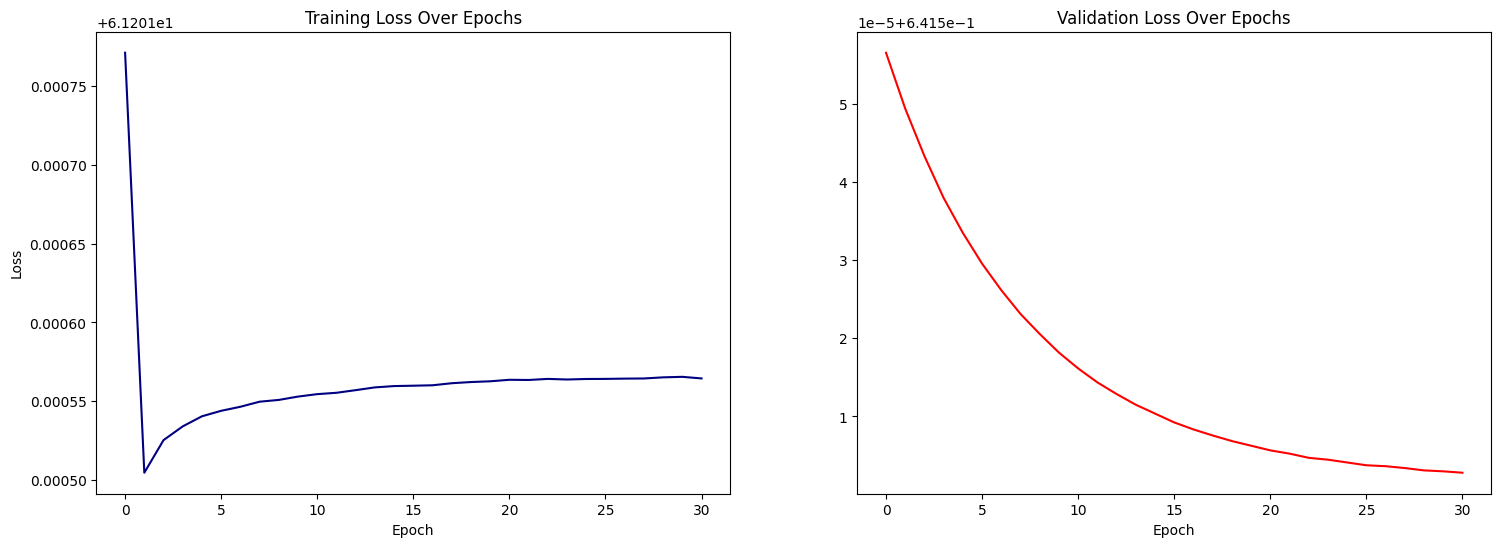

In [ ]:
train(temporal_cnn, x_train, y_train, x_test, y_test, num_epochs=50, learning_rate=0.001)

# Evaluating models

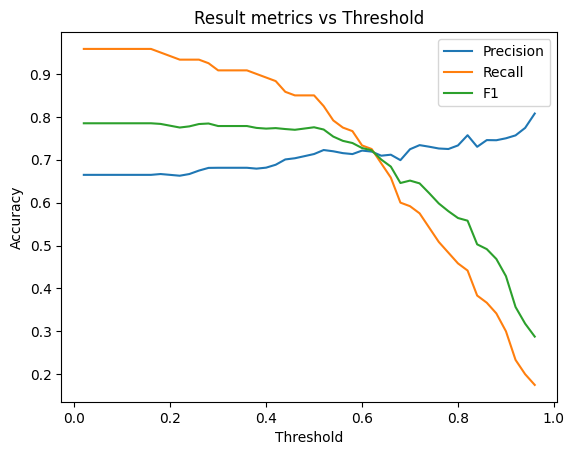

In [ ]:
def eval(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    threshold = np.arange(0.02, 0.98, 0.02)
    accuracy, precision, recall = [], [], []
    for t in threshold:
        tp = np.sum((outputs > t) & (test_HP_adhd == 1))
        tn = np.sum((outputs <= t) & (test_HP_adhd == 0))
        fp = np.sum((outputs > t) & (test_HP_adhd == 0))
        fn = np.sum((outputs <= t) & (test_HP_adhd == 1))
        # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(threshold, precision, label = 'Precision')
    plt.plot(threshold, recall, label = 'Recall')
    plt.plot(threshold, f1, label = 'F1')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Result metrics vs Threshold')
    plt.legend()
    plt.show()